Copyright (C) 2024 Pablo Castells y Alejandro Bellogín

El código que contiene este notebook se ha implementado para la realización de las prácticas de la asignatura "Sistemas de recomendación" del Máster en Ciencia de Datos, impartido en la Escuela Politécnica Superior de la Universidad Autónoma de Madrid. El fin del mismo, así como su uso, se ciñe a las actividades docentes de dicha asignatura.

### **Sistemas de recomendación 2024-25**
### Universidad Autónoma de Madrid, Escuela Politécnica Superior
### Máster en Ciencia de Datos

# Filtrado colaborativo bilineal: similitud y factorización de matrices

Fechas:

* Comienzo: martes 4 de febrero.
* Entrega: lunes 24 de febrero, 23:59.

## Autores:
* Rafael Domínguez Sáez
* Iñigo Martínez Ciriza

## Objetivos

Esta práctica tiene por objetivo la implementación y evaluación eficiente de métodos (bi)lineales de recomendación mediante filtrado colaborativo. En este bloque se desarrollarán:

* Algoritmos de filtrado colaborativo basados en similitud.
* Algoritmos de filtrado colaborativo basados en la factorización de matrices.
* Métricas de evaluación de sistemas de recomendación.

## Material proporcionado

Se proporcionan software y datos para la realización de la práctica:

* Algunas estructuras de datos ya implementadas, para manejar datos de ratings la salida de los recomendadores.
* Un esqueleto de clases y funciones donde el estudiante desarrollará sus implementaciones. 
  - Se proporciona una celda de prueba al final de este notebook que deberá funcionar con las implementaciones del estudiante.
  - Junto a la celda de prueba en este mismo notebook, se muestra como referencia un ejemplo de salida generada con una implementación de los profesores.
* Los siguientes conjuntos de datos de ratings por usuarios a items:
  - Dos conjuntos de juguete para prueba y depuración: <ins>toy1.csv</ins> (se genera en Matrices.ipynb) y <ins>toy2.csv</ins> (proporcionado en el curso Moodle) con ratings ficticios.
  - Un conjunto de datos reales de ratings a películas: *ml-1m.zip* disponible en la Web de [MovieLens](https://grouplens.org/datasets/movielens/1m). De los archivos disponibles, se utilizará sólamente <ins>ratings.dat</ins>, añadiéndole una cabecera `u::i::r::t`.
  
Los esqueletos de código que se proporcionan aquí son a modo de guía: el estudiante puede modificarlo todo libremente, siempre que la celda de prueba funcione correctamente **sin cambios**.

La entrega consistirá en un fichero tipo *notebook* donde se incluirán todas las **implementaciones** solicitadas en cada ejercicio, así como una explicación de cada uno a modo de **memoria**.

La celda de prueba deberá ejecutar sin errores a la primera con el código entregado por el estudiante (naturalmente con salvedad de los ejercicios que no se hayan implementado).

## Estructuras de datos: ratings y recomendaciones

Se proporcionan:
* Una clase Ratings que permite leer los datos de un fichero de texto, así como un método que genera dos particiones aleatorias de entrenamiento y test, para evaluar y comparar la efectividad de diferentes algoritmos de recomendación.
* Una clase Recommender que se utilizará como clase padre en todos los recomendadores.
* Una clase Recommendation para manejar la salida (rankings de items) de los recomendadores.

In [2]:
import numpy as np
import pandas as pd

class Ratings:
    def __init__(self, file=None, sep=','):
        if file:
            data = pd.read_csv(file, delimiter=sep, engine='python')
            u, i, r = data.columns[0:3]
            data.r = 1
            self.m = data.pivot(index=u, columns=i, values=r).fillna(0).to_numpy(dtype=np.float32)
            self.uids = np.sort(data[u].unique())
            self.iids = np.sort(data[i].unique())
            self.uidxs = {u:j for j, u in enumerate(self.uids)}
            self.iidxs = {i:j for j, i in enumerate(self.iids)}
            self._nratings = (self.m > 0).sum()
            self.data = data
        
    def copy(self, ratings, matrix):
        self.m = matrix
        self.uids = ratings.uids
        self.iids = ratings.iids
        self.uidxs = ratings.uidxs
        self.iidxs = ratings.iidxs
        self._nratings = (matrix > 0).sum()
        return self
    
    def matrix(self):
        return self.m
    
    def nusers(self):
        return len(self.uids)
    
    def nitems(self):
        return len(self.iids)
    
    # uidx can be an int or an array-like of ints.
    def uidx_to_uid(self, uidx):
        return self.uids[uidx]
        
    # iidx can be an int or an array-like of ints.
    def iidx_to_iid(self, iidx):
        return self.iids[iidx]
    
    def uid_to_uidx(self, uid):
        return self.uidxs[uid]
        
    def iid_to_iidx(self, iid):
        return self.iidxs[iid]
        
    def iidx_rated_by(self, uidx):
        self.m[uidx].nonzero()
        
    def uidx_who_rated(self, iidx):
        self.m[:, iidx].nonzero()
        
    def random_split(self, ratio):
        mask = np.random.choice([True, False], size=self.m.shape, p=[ratio, 1-ratio])
        train = self.m * mask
        test = self.m * ~mask
        return Ratings().copy(self, train), Ratings().copy(self, test)
    
    def sequence_split(self):
        # self.data.columns = ['u', 'i', 'r', 't']
        test_ids = [group.sort_values(by='t', ascending=False)[['u', 'i']].to_numpy()[0] 
                    for _, group in self.data.groupby(by='u')]
        test_idx = np.array([[self.uid_to_uidx(uid), self.iid_to_iidx(iid)] for uid, iid in test_ids])
        mask = np.ones(self.matrix().shape)
        mask[test_idx[:, 0], test_idx[:, 1]] = 0
        train = self.m * mask
        test = self.m * (1-mask)
        return Ratings().copy(self, train), Ratings().copy(self, test)
    
    #
    # The remaining functions are just for debugging purposes.
    #

    def rating(self, uid, iid):
        return self.matrix()[self.uid_to_uidx(uid), self.iid_to_iidx(iid)]

    def items_rated_by(self, uid):
        return self.iidx_to_iid(self.iidx_rated_by(self.uid_to_uidx(uid)))
        
    def users_who_rated(self, iid):
        return self.uidx_to_uid(self.uidx_who_rated(self.iid_to_iidx(iid)))
    
    def user_ratings(self, uid):
        iidxs = self.matrix()[self.uid_to_uidx(uid)].nonzero()[0]
        return {self.iidx_to_iid(iidx): fround(r) for iidx, r in zip(iidxs, self.matrix()[self.uid_to_uidx(uid), iidxs])}

    def item_ratings(self, iid):
        uidxs = self.matrix()[:, self.iid_to_iidx(iid)].nonzero()[0]
        return {self.uidx_to_uid(uidx): fround(r) for uidx, r in zip(uidxs, self.matrix()[uidxs, self.iid_to_iidx(iid)])}

    def nratings(self):
        return self._nratings
 
    def save(self, file):
        df = pd.DataFrame(columns=self.iids, index=self.uids, data=self.m).unstack().reset_index(name='r')
        df.columns = ['i', 'u', 'r']
        df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'])
        df.to_csv(file, index=False)

from itertools import islice

# Given a matrix, returns a matrix of positions of top k values per row.
def top_positions_per_row(m, k):
    return np.argpartition(m, -k)[:, -k:]

class Recommendation:
    def __init__(self, scores, n, training):
        scores = scores * (training.matrix() == 0) # Don't recommend rated items.
        # We sort the positions in top_iidx just in order to keep the NumPy tie break by original position 
        # (i.e. by ascending object ID) when we use this function later.
        top_iidx = np.sort(top_positions_per_row(scores, min(n, training.nitems())))
        # We sort by -scores because NumPy sorts by ascending and we want descending.
        self.iidx_ranking = np.take_along_axis(top_iidx, np.argsort(-np.take_along_axis(scores, top_iidx, axis=1)), axis=1)
        self.rank_scores = np.take_along_axis(scores, self.iidx_ranking, axis=1)
        ranked_iids = training.iidx_to_iid(self.iidx_ranking)
        self._recommendation = {training.uidx_to_uid(uidx) : [(iid, score) for iid, score in zip(ranked_iids[uidx], self.rank_scores[uidx]) if score > 0]
                                for uidx in range(training.nusers())}

    def ranked_iidx(self):
        return self.iidx_ranking
        
    def recommendation(self, uid):
        return self._recommendation[uid]
        
    # This function is for debuggind purposes.
    # Format the recommendation as a string for the first n users. Trim scores to 4 decimal digits.
    def display(self, n):
        r = ''
        for uid in islice(self._recommendation, n):
            r += f'    User {uid} -> <' 
            for iid, score in self.recommendation(uid): 
                r += f'{iid}:{str(fround(score, 4))} '
            r = (r[:-1] + '>\n') if len(self.recommendation(uid)) > 0 else r + 'empty>\n'
        return r[:-1]
        
class Recommender():
    def __init__(self, training):
        self.training = training

    def __repr__(self):
        return type(self).__name__

    def recommend(self, n):
        return Recommendation(self.scores, n, self.training)

# Just for pretty-printing numbers.
def fround(x, n=20):
    r = round(x)
    rn = round(x, n)
    return r if rn == r else rn

## Ejercicio 1: Recomendación simple no personalizada

La **salida** de un recomendador consistirá en un diccionario con un ránking por usuario. 

Implementar un primer **recomendador simple** por rating promedio en una clase `AverageRecommender`. El recomendador sólo recomendará items que tengan un mínimo número de ratings, que se indicará como parámetro en el constructor (con ello se mejora el acierto de la recomendación). Se proporciona una clase `MajorityRecommender` a modo de ejemplo en el que el estudiante podrá basarse, así como `RandomRecommender`, que se utiliza en ocasiones como referencia en experimentos. 

In [22]:
# Suggestion: compute the scores in each recommenders' constructor.

class RandomRecommender(Recommender):
    def __init__(self, training):
        super().__init__(training)
        self.scores = np.random.random(training.matrix().shape)

class MajorityRecommender(Recommender):
    def __init__(self, training, threshold=0):
        super().__init__(training)
        # training.matrix() >= threshold creates a mask with 'True' on relevant ratings and 'False' anywhere
        # else. Thus 'pop' is an array with the counts of relevant ratings of each item.
        pop = np.sum(training.matrix() >= threshold, axis=0)
        # This product by a vector of ones (of user-row length) creates a matrix where the pop vector gets
        # copied on all rows; the recommendation is not personalized and ranking is the same for all users 
        # -- except of course in the end different training items will be filtered out for different users.
        self.scores = np.outer(np.ones(training.nusers()), pop)

class AverageRecommender(Recommender):
    def __init__(self, training, minr=0):
        super().__init__(training)
        # Creamos una máscara para los items que han sido evaluados al menos minr veces
        n_ratings = np.count_nonzero(training.matrix(), axis=0)
        mask = n_ratings >= minr

        # Aplicamos la máscara a la matriz de evaluaciones
        mask_scores = (training.matrix() * mask)

        # Contamos el número de evaluaciones evitando divisiones entre 0 marcando al menos 1 evaluación por item
        n_ratings *= mask
        n_ratings[n_ratings == 0] = 1

        # Calculamos la evaluación como la media de todas las evaluaciones
        self.scores = np.outer(np.ones(training.nusers()), np.sum(mask_scores, axis=0) / n_ratings)

### Ejercicio 1 &ndash; Explicación/documentación

El objetivo de la calse `Ratings` es la de poder implementar las opearciones vistas y estudiadas a una matriz de ratings. Sobre cada item $i$ perteneciente a un conjunto, un usuario $u$ puede asignar un rating (o evaluación) de dicho item tal que $r(u,i)$. Sin embargo, no todos los usuarios realizarán evaluaciones de todos los items. Así, para identificar estos usuarios e items, la clase utiliza las variables `uidx` (para los usuarios) y `iidx` (para los items). Así, cada evaluación dentro de la matriz de ratings $r(u,i)$ se puede localizar a partir de `ratings[uidx][iidx]`.

El objetivo de la clase `Recommender` es la de crear recomendadores que, a partir de la información contenida en la matriz de ratings, realicen predicciones sobre items que resultan de interés a los usuarios. Para ello, se realizan recomendaciones a partir de los ratings estimados $\hat{r}(u,i)$. Para conocer cómo de buena es una recomendación, se divide el conjunto de datos de la matriz de ratings en la parte de entrenamiento y en la parte de test.

El recomendador que hemos aplicado en este ejercicio es el `AverageRecommender`, el cual basa sus recomendaciones en los ratings promedios para dicho item. Cuanto mayor sea el rating promedio de un item, más se recomendará dicho item a los usuarios. Así, para cada usuario las recomendaciones son idénticas, no hay ninguna personalizaión. Este recomendador además no recomienda items a los usuarios si ya los han puntuado.

## Ejercicio 2: Recomendación basada en similitud &ndash; kNN

Implementar un algoritmo de filtrado colaborativo mediante vecinos próximos orientado a usuarios por *similitud coseno* (sin normalizar por la suma de similitudes). 

In [24]:
class CosineUserSimilarity:
    def __init__(self, training):
        # Calculamos la similitud de todos los usuarios consigo mismos
        dots = np.dot(training.matrix(),training.matrix().T)

        # Obtenemos el vector de módulos de cada usuario
        mods = np.sqrt(dots.diagonal())
        mods[mods==0] = 1
        
        # Creamos una matriz de similitud de cosenos entre usaurios
        # La similitud entre un usuario y él mismo es 0
        self.sim = (dots/mods).T/mods
        np.fill_diagonal(self.sim,0)
    
    def sim_matrix(self):
        return self.sim

class UserKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)

        # Obtenemos los k vecinos más cercanos de cada usuario
        knn = top_positions_per_row(sim.sim_matrix(), k)

        # Creamos una máscara para los k vecinos más cercanos con 1 si es vecino y 0 en caso contrario
        mask = np.zeros_like(sim.sim_matrix())
        mask[np.arange(mask.shape[0]), knn.T] = 1

        # Creamos una máscara para la matriz de similitud
        knn_sim = sim.sim_matrix() * mask

        # Calculamos los scores de la recomendación kNN
        self.scores = knn_sim@training.matrix()

### Ejercicio 2 &ndash; Explicación/documentación

Para realizar las estimaciones de ratings, utilizamos un método basado en similitud. Así, a un usuario se le recomendarán ítems que sus $k$ usuarios más similares hayan dado un rating alto.
Para calcular esta similitud, se calcula el coseno entre dos usuarios de la matriz de ratings de entrenamiento. Este coseno mide el ángulo entre dos usuarios en un espacio de ratings, de forma que cuanto más cercano sea a 1 (el ángulo sea más cercano a 0), más similares serán estos dos usuarios.

Además, consideramos que no es buena idea recomendar ítems a un usuario que ya han sido evaluados por este mismo usuario y como la similitud de un usuario consigo mismo es siempre 1, todas las diagonales de la matriz de similitud se ignoran para calcular los scores.

Por tanto, el filtrado colaborativo usando kNN obtiene los scores de los $k$ usuarios con similitud más alta y calcula la recomendación tal que:

$\hat{r}(u,i) = \sum_{v \in V} sim(u,v) \cdot r(v,i)$

## Ejercicio 3: Factorización de matrices

Implementar filtrado colaborativo mediante factorización de matrices.

In [29]:
from matplotlib import pyplot as plt
import matplotlib
import datetime, time

def plot(train_losses, test_values=[], test_metrics=[]):
    f = plt.figure()
    plt.plot(range(len(train_losses)), train_losses, color='blue', linewidth=.7, label='Training MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Training error')
    ax = plt.gca().twinx()
    for m, m_name, color in zip(test_values, test_metrics, ['tab:red', 'darkgreen', 'darkorange', 'darkviolet']):
        ax.plot(range(len(m)), m, linewidth=.7, color=color, label=f'Test {m_name}')
        plt.ylabel('Test metric')
    f.legend(loc='center right', bbox_to_anchor=(0.85, 0.5))
        
def print_progress(rec, start, epoch, error, test_values, test_metrics):
    output = f'\rTraining MF --> Epochs: {epoch+1}  Training error: {error}  '
    if test_metrics: output += 'Test metrics: ' 
    for values, metric in zip(test_values, test_metrics): 
        val = metric.compute(rec.recommend(metric.cutoff))
        output += f'{metric} = {val}  '
        values.append(val)
    output += f' \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m'
    print(output, end='              ')
        
class MF(Recommender):
    def __init__(self, training, dim=50, lrate=.001, nepochs=20, test_metrics=[]):
        super().__init__(training)
        p,q = self.train(dim, lrate, nepochs, test_metrics)
        self.scores = self.predict(p,q)
        
    def predict(self, p, q):
        return (p @ q.T)
        
    def train(self, dim, lrate, nepochs, test_metrics):
        # 50x3
        p = abs(np.random.normal(scale=1/self.training.nusers(), size=(self.training.nusers(), dim)))
        # 10x3
        q = abs(np.random.normal(scale=1/self.training.nitems(), size=(self.training.nitems(), dim)))
        
        train_errors, test_values = [], [[] for _ in test_metrics]
        start = time.time()
        for epoch in range(nepochs):
            self.scores = self.predict(p,q)
            err = self.training.matrix() - self.scores #50x10
            
            p += lrate * (err @ q)   #50x10 @ 10x3 -> 50x3
            q += lrate * (err.T @ p) #10x50 @ 50x3 -> 10x3

            e = (err**2).mean()
            train_errors.append(e)
            print_progress(self, start, epoch, e, test_values, test_metrics)
        print()
        # Don't plot for small datasets.
        if self.training.nratings() > 1000 : plot(train_errors, test_values, test_metrics)
        return p, q

### Ejercicio 3 &ndash; Explicación/documentación

También se pueden realizar recomendaciones a los usuarios representando tanto a los usuarios como a los ítems en función de un vector de características.

Así, se utilizan espacios que puedan representar sus gustos y sean más efectivos que calcular la similitud entre usuarios con kNN. Por tanto, la recomendación pasa a definirse de forma mucho más sencilla tal que $\hat{r}(u,i) = u \cdot i$. El problema es encontrar la representación de los usuarios e ítems en este espacio de características.

Para encontrar los parámetros del modelo que definen el espacio de características usaremos un entrenamiento basado en minimizar el error cuadrático medio $MSE=(r(u,i) - u \cdot i)^2$ para cada usuario e ítem.
Para ello, utilizamos las matrices $P$ de dimensión $|U|\times k$ y $Q$ de dimensión $|I| \times k$.

## Ejercicio 4: Evaluación

Se desarrollarán clases que permitan calcular métricas para evaluar y comparar el acierto de los recomendadores: se implementarán **precisión** y **recall**. 

Como resumen de este bloque, se incluirá una *tabla con los valores de las métricas* (dos columnas) más el tiempo de ejecución (una columna más) sobre todos los algoritmos implementados (filas), al menos para el conjunto de datos de <ins>MovieLens 1M</ins>. En el caso de ser capaces de procesar un conjunto de datos más grande, se documentará el tamaño en RAM de la matriz de ratings.

<!-- Opcionalmente, se podrán implementar otras métricas a elección del estudiante (nDCG, etc.), cuya prueba se incluirá en la función `student_test()` del ejercicio 4 ("ampliaciones"). -->

In [20]:
class Metric():
    def __init__(self, cutoff):
        self.cutoff = cutoff

    def __repr__(self):
        return type(self).__name__ + ('@' + str(self.cutoff) if self.cutoff != np.inf else '')

class Precision(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        # Umbral para considerar un ítem como relevante
        self.threshold = threshold

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]
        
        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.sum(relevant_m, axis=1) / self.cutoff).mean()

class Recall(Metric):
    def __init__(self, test, cutoff=np.inf, threshold=1):
        super().__init__(cutoff)
        self.test = test
        self.threshold = threshold
        self.individual_relevant = np.sum(test.matrix() >= threshold, axis=1)
        self.individual_relevant[self.individual_relevant == 0] = 1

    def compute(self, recommendation):
        k_recommendations = recommendation.ranked_iidx()[:, :self.cutoff]
        
        x = np.take_along_axis(self.test.matrix(), k_recommendations, axis=1)
        relevant_m = x >= self.threshold

        return (np.divide(np.sum(relevant_m, axis=1), self.individual_relevant)).mean()


### Ejercicio 4 &ndash; Explicación/documentación

Para evaluar los algoritmos implementados, se pueden utilizar dos medidas que hemos visto en clase:

* Precision: mide cuántos de los elementos recomendados son realmente relevantes sobre el número total de elementos.
* Recall: mide cuántos de los elementos relevantes han sido recuperados en la recomendación sobre el número de elementos relevantes totales.

La relevancia de un elemento se refiere a los propios ratings de los usuarios sobre los ítems. Los ítems con un ranting de usuario $r(u,i)$ superior a cierto threshold será considerado relevante y el resto se descartan.

Para ambas métricas se utilizan las matrices `x` e `y` que son representaciones de las condiciones que se deben cumplir:

* El conjunto de scores de cada usuario (hasta el número de elementos cutoff).
* El conjunto de scores que cumplen con el threshold esperado.

Ambas métricas se obtienen al operar sobre el resultado obtenido de multiplicar las matrices `x` e `y` y pasarán a contener valores binarios:

* Precision: media de 1 por fila dividido por el cutoff.
* Recall: media de 1 por fila dividido entre el número de ítems relevantes.

Ahora vamos a estudiar los valores de estas métricas para los diferentes algoritmos que hemos implementado hasta ahora: `RandomRecommender`, `MajorityRecommender`, `AverageRecommender`, `UserKNNRecommender` y `MFRecommender`. Para ello, utilizaremos el dataset de MovieLens que contiene el rating de 1 millón de películas.

Ejemplo de tabla de resumen:

||Precision@K|Recall@K|Tiempo de ejecución
|-|:-:|:-:|:-:
|RandomRecommender|...|...|...
|MajorityRecommender|...|...|...
|AverageRecommender|...|...|...
|UserKNNRecommender|...|...|...
|MFRecommender|...|...|...

## Ejercicio 5: Ampliaciones

* Implementar otra variante de kNN a elección del estudiante.
* Probar otras funciones de pérdida en MF.
* Crear una implementación de las estructuras de ratings con matrices dispersas, de forma que sea posible generar recomendaciones sobre conjuntos de datos más grandes, tales como [MovieLens 10M](https://grouplens.org/datasets/movielens/10m) y [MovieLens 25M](https://grouplens.org/datasets/movielens/25m).
* Otra(s) idea(s) de ejercicio a propuesta del estudiante, consultando con el profesor.

Para probar las implementaciones deberá completarse la función `student_test()` para ilustrar la ejecución de las variantes adicionales, y se incluirán las filas que correspondan en la tabla del apartado anterior.

In [10]:
class CosineItemSimilarity:
    def __init__(self, training):
        # Calculamos la similitud de todos los ítems consigo mismos
        dots = np.dot(training.matrix().T,training.matrix())

        # Obtenemos el vector de módulos de cada ítem
        mods = np.sqrt(dots.diagonal())
        mods[mods==0] = 1

        # Creamos una matriz de similitud de cosenos entre usaurios
        # La similitud entre un usuario y él mismo es 0
        self.sim = (dots/mods).T/mods
        np.fill_diagonal(self.sim,0)

    def sim_matrix(self):
        return self.sim

class ItemKNNRecommender(Recommender):
    def __init__(self, training, sim, k):
        super().__init__(training)

        # Obtenemos los k vecinos más cercanos de cada usuario
        knn = top_positions_per_row(sim.sim_matrix(), k)

        # Creamos una máscara para los k vecinos más cercanos con 1 si es vecino y 0 en caso contrario
        mask = np.zeros_like(sim.sim_matrix())
        mask[np.arange(mask.shape[0]), knn.T] = 1

        # Creamos una máscara para la matriz de similitud
        knn_sim = sim.sim_matrix() * mask
        
        # Calculamos los scores de la recomendación kNN
        self.scores = knn_sim@training.matrix()

def student_test():
    # Código de prueba aquí...
    pass

### Ejercicio 5 &ndash; Explicación/documentación

Una alternativa a kNN basado en usuario es el kNN basado en ítems. Éste se calcula de forma sencilla trasponiendo la matriz con la que estamos trabajando. En lugar ahora de realizar recomendaciones de usuario basado en los ratings de otros usuarios similares, ahora la recomendación se basa en los propios ítems. Así, a un usuario que valore positivamente un ítem se le recomendará los ítems similares al que ha valorado, en lugar de los ítems de otro usuario similar a él.

La similitud entre ítems se calcula de forma análoga a la similitud entre usuarios. Se utiliza el coseno del ángulo entre los vectores de ítems para estudiar los ítems más similares. Simplemente debemos invertir el orden de multiplicación de las matrices y trasponer las matrices correspondientes para obtener las dimensiones correctamente.

## Celda de prueba

Descarga los ficheros de datos y coloca sus contenidos en una carpeta **data** en el mismo directorio que este *notebook*.

Testing toy 1 dataset
Reading the data at 08:33:45...
Ratings matrix takes 0.0 MB in RAM
--> elapsed time: 0:00:00 <--
-------------------------
Testing the ratings data structures
11 ratings by 4 users on 5 items
Ratings of user v: {'b': 1, 'c': 1, 'd': 1}
Ratings of item b: {'v': 1, 'x': 1, 'y': 1}
-------------------------
Testing RandomRecommender (top 4)
Four example recommendations:
    User v -> <a:0.9786 e:0.1183>
    User x -> <c:0.9447 d:0.5218>
    User y -> <d:0.5684 e:0.0188>
    User z -> <e:0.6818 a:0.6176 c:0.6169 b:0.6121>
Precision@4 = 0.0625
Recall@4 = 0.25
--> elapsed time: 0:00:00 <--
-------------------------
Testing MajorityRecommender (top 4)
Four example recommendations:
    User v -> <a:2 e:1>
    User x -> <c:2 d:2>
    User y -> <d:2 e:1>
    User z -> <b:3 a:2 c:2 e:1>
Precision@4 = 0.0625
Recall@4 = 0.25
--> elapsed time: 0:00:00 <--
-------------------------
Testing AverageRecommender (top 4)
Four example recommendations:
    User v -> <a:1>
    User x ->

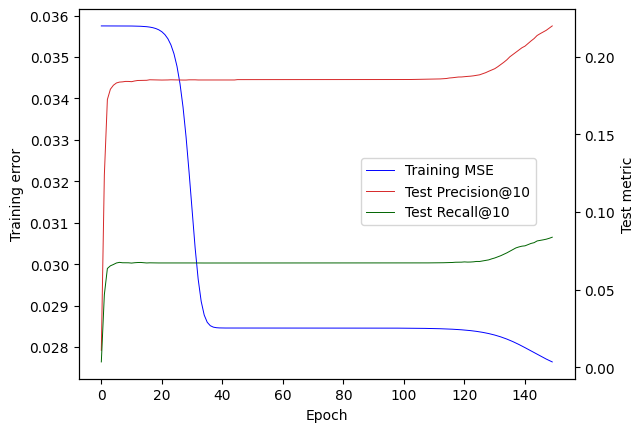

In [30]:
import datetime, time

# Test data structures and algorithms on a dataset.
def test(ratings_file, example_user, example_item, k, minr, dim, topn=np.inf, cutoff=np.inf, threshold=1, sep=','):
    print(colored(f'Reading the data at ' + time.strftime('%X...'), 'blue'))
    start = time.time()
    ratings = Ratings(ratings_file, sep)
    print(f'Ratings matrix takes {round(10 * ratings.matrix().nbytes / 1024 / 1024) / 10:,} MB in RAM')
    timer(start)

    # Test Ratings class on the dataset.
    test_data(ratings, example_user, example_item)
    
    # Produce a rating split and test a set of recommenders. 
    train, test = ratings.random_split(0.8)
    metrics = [Precision(test, cutoff=cutoff, threshold=threshold), Recall(test, cutoff=cutoff, threshold=threshold)]
    run_recommenders(train, metrics, k, minr, dim, topn)

# Test the rating data handling code (Ratings class).
def test_data(ratings, example_user, example_item):
    print('-------------------------\nTesting the ratings data structures')
    print(f'{ratings.nratings():,} ratings by {ratings.nusers():,} users on {ratings.nitems():,} items')
    print(f'Ratings of user {example_user}: {ratings.user_ratings(example_user)}')
    print(f'Ratings of item {example_item}: {ratings.item_ratings(example_item)}')

# Run some recommenders on the some rating data as input - no evaluation.
def run_recommenders(train, metrics, k, minr, dim, topn):
    print('-------------------------')
    start = time.time()
    run_recommender(RandomRecommender(train), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(MajorityRecommender(train, threshold=1), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    run_recommender(AverageRecommender(train, minr), metrics, topn)
    start = timer(start)
    
    print('-------------------------')
    print('Creating user cosine similarity')
    sim = CosineUserSimilarity(train)
    start = timer(start)
    print('Creating kNN recommender')
    knn = UserKNNRecommender(train, sim, k)
    start = timer(start)
    run_recommender(knn, metrics, topn)
    timer(start)

    print('-------------------------')
    start = time.time()
    print('Creating MF recommender')
    mf = MF(train, dim=dim, lrate=.0005, nepochs=150, test_metrics=metrics)
    start = timer(start)
    run_recommender(mf, metrics, topn)
    timer(start)

# Run a recommender and evaluate a list of metrics on its output.
def run_recommender(recommender, metrics, topn):
    print(f'Testing {recommender} (top {topn})')
    recommendation = recommender.recommend(topn)
    print('Four example recommendations:\n' + recommendation.display(4))
    for metric in metrics:
        print(metric, '=', metric.compute(recommendation))

from termcolor import colored
def timer(start):
    print(colored(f'--> elapsed time: {datetime.timedelta(seconds=round(time.time() - start))} <--', 'blue'))
    return time.time()
    
np.random.seed(0)
print('=========================\nTesting toy 1 dataset')
test('data/toy1.csv', example_user='v', example_item='b', k=4, minr=2, dim=5, topn=4, cutoff=4)
print('=========================\nTesting toy 2 dataset')
test('data/toy2.csv', example_user=1, example_item=2, k=4, minr=2, dim=5, topn=4, cutoff=4)
print('=========================\nTesting MovieLens \'1 million\' dataset')
test('data/ratings-1m.dat', example_user=200, example_item=1000, k=10, minr=3, dim=20, topn=10, cutoff=10, sep='::')
print('=========================\nDone.')

# Additional testing?
student_test()

### Salida obtenida por el estudiante

*(por hacer)*